## Example

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from scipy.stats.mstats import winsorize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ABCD_ML.ML as ML
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

Within this notebook we shall be considering the usage of ABCD data, structural + 3 tasks + resting state (LR flipped subjects filtered out), towards the prediction of "Pic Vocab Scores".

Specifically, we begin by considering the data without any pre-proccesing or scaling, as we would like to quantify the effects of these choices. 

Min 29.0 Max 119.0


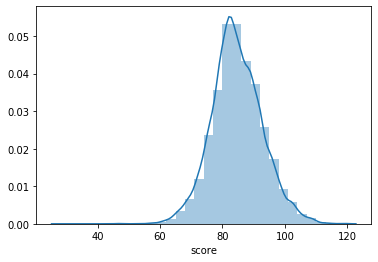

In [3]:
data = pd.read_csv('Data/Pic_Vocab_data.csv')

print('Min', np.min(data.score), 'Max', np.max(data.score))

sns.distplot(data.score, bins=30)
plt.show()

In [17]:
q = (3, 99)
q[0]
type(data.score)


pandas.core.series.Series

The distribution looks mostly okay, but the score of 29 is worrying

In [3]:
data = data[data.score > (np.mean(data.score) - 5 * np.std(data.score))]
print('Min', np.min(data.score), 'Max', np.max(data.score))

Min 47.0 Max 119.0


We want to ensure that the target variable does not contain any horrendeous outliers, as this would have negative effects upon choice of scoring metric. And next we want to check to input dataset for severe outliers as well.

In [4]:
X = np.array(data.drop('score', axis=1))
y = np.array(data.score)
np.min(X), np.max(X)

(0.0, 2101702.699345)

Of which there clear are some, we can simply try winsorizing these values to 2%

In [5]:
X = winsorize(X, (.02), axis=0).data
np.min(X), np.max(X)

(0.0, 1823760.14072)

There exist a number of different cross validation stratagies, what we hope to determine is a reasonable balanced between over cautiousness, and over-estimating performance. As the over-arching analysis involves a model selection phase, best practice would suggest explicitly witholding a testing set, rather than performing cross-validation across the whole dataset. We will examine exactly how these choices can lead to different outcomes. 

In [6]:
#Strategy 1, split the dataset initially into train and test, with 25% towards the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 638), (2500, 638), (7500,), (2500,))

First we can explore on our training set the effect of different data scaling schemes, running each model/expiriment with 3-fold CV, repeated 5 random times, which gives use the mean performance and std, in r2_score. For now we will just consider a few models, without delving too deep into different params for each classifier. 

In [9]:
scalers = [None, StandardScaler(), MinMaxScaler(),
          RobustScaler(quantile_range=(1, 99)), RobustScaler(quantile_range=(5, 95))]

for scaler in scalers:
    print('with: ', scaler)
    
    if scaler != None:
        X_train_scaled = scaler.fit_transform(X_train)
    else:
        X_train_scaled = X_train
    
    score, std = ML.evaluate_regression_model(X_train_scaled, y_train, model_type='linear', n_splits=3, n_repeats=5, int_cv=3, metric='r2')
    print('linear model: ', score, std)

    score, std = ML.evaluate_regression_model(X_train_scaled, y_train, model_type='elastic cv', n_splits=3, n_repeats=5, int_cv=3, metric='r2')
    print('elastic net model: ', score, std)
    
    score, std = ML.evaluate_regression_model(X_train_scaled, y_train, model_type='full lightgbm', n_splits=3, n_repeats=5, int_cv=3, metric='r2', extra_params={'n_jobs': 8})
    print('Light GBM: ', score, std)
    print()

with:  None
linear model:  0.0468685533312011 0.0051827326204520125
elastic net model:  0.0827875194260192 0.0007335882892701813
Light GBM:  0.11036828137567563 0.0036602266115117305

with:  StandardScaler(copy=True, with_mean=True, with_std=True)
linear model:  0.0524220945375949 0.00469154893876985
elastic net model:  0.12895807653864172 0.0013542291686499278
Light GBM:  0.10882123085095377 0.0021972057803476925

with:  MinMaxScaler(copy=True, feature_range=(0, 1))
linear model:  0.051598167770137114 0.0026354881157360944
elastic net model:  0.13265114183893187 0.0008209709069561236
Light GBM:  0.11034160556023173 0.00470473098201312

with:  RobustScaler(copy=True, quantile_range=(1, 99), with_centering=True,
             with_scaling=True)
linear model:  0.04571488878181869 0.010083996393728815
elastic net model:  0.13075360937847394 0.0019668401673187427
Light GBM:  0.10906225195093673 0.003906957638178578

with:  RobustScaler(copy=True, quantile_range=(5, 95), with_centering=True,

An additional consideration besides scaling, is correcting for skew in the features, either through a log transform or a box-cox transform. Note when box-cox transform param lambda == 0, then it is the same as log1p transform.

In [10]:
from scipy.stats import skew
from scipy.special import boxcox1p

print('baseline score')
score, std = ML.evaluate_regression_model(X_train, y_train, model_type='linear', n_splits=3, n_repeats=5, int_cv=3, metric='r2')
print('linear model: ', score, std)

score, std = ML.evaluate_regression_model(X_train, y_train, model_type='elastic cv', n_splits=3, n_repeats=5, int_cv=3, metric='r2')
print('elastic net model: ', score, std)
print()

skew_values = [.25, .5, .75, 1]

for skew_value in skew_values:
    
    skewed_ind = np.abs(skew(X_train, axis=0)) > skew_value
    print('with skew value ', skew_value, ':', np.sum(skewed_ind), 'features to transform')
    print()
    
    for lam in [0, .1, .15, .2, .25]:
    
        X_train_skew_corrected = np.copy(X_train)
        X_train_skew_corrected[:,skewed_ind] = boxcox1p(X_train_skew_corrected[:,skewed_ind], lam)
        
        print('with lambda param: ', lam)

        score, std = ML.evaluate_regression_model(X_train_skew_corrected, y_train, model_type='linear', n_splits=3, n_repeats=5, int_cv=3, metric='r2')
        print('linear model: ', score, std)
        
        score, std = ML.evaluate_regression_model(X_train_skew_corrected, y_train, model_type='elastic cv', n_splits=3, n_repeats=5, int_cv=3, metric='r2')
        print('elastic net model: ', score, std)
        
    print()
    
    
    

baseline score
linear model:  0.05188942927548638 0.007448188046957814
elastic net model:  0.08325239979204697 0.0008041439214554197

with skew value  0.25 : 342 features to transform

with lambda param:  0
linear model:  0.05673938798370951 0.004573631240035023
elastic net model:  0.08214261296124337 0.001471008543987945
with lambda param:  0.1
linear model:  0.05030588828196993 0.007593012144176927
elastic net model:  0.08281640848215946 0.0008103449362915382
with lambda param:  0.15
linear model:  0.05456787931601873 0.004518668810763542
elastic net model:  0.08235979592170037 0.0013328155196598644
with lambda param:  0.2
linear model:  0.04653438696534945 0.007867477153460827
elastic net model:  0.0830903474832779 0.0008885565196939488
with lambda param:  0.25
linear model:  0.05154330676894061 0.006760256816036781
elastic net model:  0.08307030145245511 0.0006329628325552071

with skew value  0.5 : 123 features to transform

with lambda param:  0
linear model:  0.04304825366384261